In [22]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

### I - Data generation and performance criteria

In [23]:
# Question 1

def generate_data(k, m, n, sigma=10.0):

    assert k <= n
    assert sigma > 0

    x = np.zeros(n)
    a = np.floor(np.linspace(0, n - 1, num=k)).astype(int)
    s = np.random.randn(k)
    x[a] = s + np.sign(s)

    A = np.random.randn(m, n)
    A /= np.linalg.norm(A, axis=0)

    y = A @ x

    e = np.random.randn(m)
    e *= np.linalg.norm(y, 2) / (np.sqrt(sigma) * np.linalg.norm(e, 2))
    y += e

    return x, A, y

def snr(xtrue, A, y):
    return np.linalg.norm(A @ xtrue)**2 / np.linalg.norm(y - A @ xtrue)**2

In [24]:
k, m, n = 10, 50, 100
xtrue, A, y = generate_data(k, m, n)

print("Shape of xtrue : {}".format(xtrue.shape))
print("Shape of A     : {}".format(A.shape))
print("Shape of y     : {}".format(y.shape))
print("Nnz in xtrue   : {}".format(np.flatnonzero(xtrue).size))
print("SNR            : {:.2f}".format(snr(xtrue, A, y)))

Shape of xtrue : (100,)
Shape of A     : (50, 100)
Shape of y     : (50,)
Nnz in xtrue   : 10
SNR            : 10.00


In [25]:
# SNR checks

for sigma in [1., 2., 5., 10.]:
    print("Sigma :", sigma)
    xtrue, A, y = generate_data(k, m, n, sigma=sigma)
    print("  Signal squared-norm : {:.2f}".format(np.linalg.norm(A @ xtrue, 2)**2))
    print("  Noise squared-norm  : {:.2f}".format(np.linalg.norm(y - A @ xtrue, 2)**2))
    print("  SNR                 : {:.2f}".format(snr(xtrue, A, y)))

Sigma : 1.0
  Signal squared-norm : 40.24
  Noise squared-norm  : 40.24
  SNR                 : 1.00
Sigma : 2.0
  Signal squared-norm : 29.66
  Noise squared-norm  : 14.83
  SNR                 : 2.00
Sigma : 5.0
  Signal squared-norm : 33.73
  Noise squared-norm  : 6.75
  SNR                 : 5.00
Sigma : 10.0
  Signal squared-norm : 25.96
  Noise squared-norm  : 2.60
  SNR                 : 10.00


In [26]:
# Question 2

def signal_error(x_true, x_hat):
    return np.linalg.norm(x_true - x_hat, 2)**2 / x_true.size

def target_error(y, Ax_hat):
    return np.linalg.norm(y - Ax_hat, 2)**2 / y.size

def fscore(xtrue, x):
    S = (np.abs(x) > 1e-8)
    Strue = (np.abs(xtrue) > 1e-8)
    if (np.sum(S) == 0.) or (np.sum(Strue) == 0.):
        return 0.
    P = np.sum(S & Strue) / np.sum(Strue)
    R = np.sum(S & Strue) / np.sum(S)
    F = 2 * P * R / (P + R)
    return F

### II - Thresholding methods

In [27]:
# Question 1

# - Number of iterations : it >= maxit
# - No progression of the iterate : |xnew - x| <= tol
# - Accuracy : |y - Ax| <= tol
# - ...

In [28]:
# Question 2

def threshold(x, k):
    z = np.zeros(x.shape)
    idx = np.argsort(np.abs(x))[::-1][:k]
    z[idx] = x[idx]
    return z

In [29]:
# Question 3

def iht(A, y, k, alpha=0.1, maxit=1000, tol=1e-4):
    _, n = A.shape
    x = np.zeros(n)
    z = np.zeros(n)
    it = 0
    while True:
        it += 1
        xold = np.copy(x)
        z = x + alpha * A.T @ (y - A @ x)
        x = threshold(z, k)
        if it >= maxit:
            break
        if np.linalg.norm(x - xold)**2 <= tol: #target_error(y, A @ x) <= tol:
            break
    return x, it

In [30]:
# Question 4

k, m, n = 5, 50, 100
xtrue, A, y = generate_data(k, m, n)
x, it = iht(A, y, k)
print("F-score : {:.4f}".format(fscore(xtrue, x)))
print("S-error : {:.4f}".format(signal_error(xtrue, x)))
print("T-error : {:.4f}".format(target_error(y, A @ x)))

F-score : 0.8000
S-error : 0.0157
T-error : 0.0347


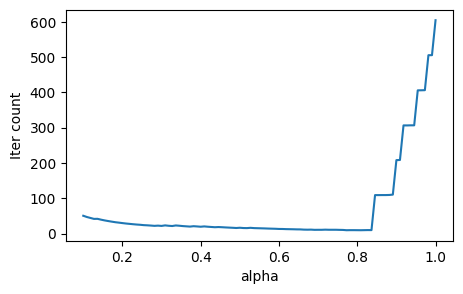

In [31]:
# Question 5

k, m, n = 5, 50, 100
repeats = 10
alpha_values = np.linspace(0.1, 1., num=100)
iter_count = [[] for _ in alpha_values]
for rep in range(repeats):
    xtrue, A, y = generate_data(k, m, n)
    for i, alpha in enumerate(alpha_values):
        x, it = iht(A, y, k, alpha=alpha)
        iter_count[i].append(it)

iter_count_averaged = [np.mean(vals) for vals in iter_count]

f, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(alpha_values, iter_count_averaged)
ax.set_ylabel("Iter count")
ax.set_xlabel("alpha");

### III - Greedy procedures

In [32]:
# Question 2

# P_k : stop when iter >= k
# P_e : stop when error <= tol
# P_l : stop when objective no longer decreases

In [43]:
# Question 3

def omp(A, y, k=None, e=None, l=None):
    assert (k is not None) or (e is not None) or (l is not None)
    m, n = A.shape
    r = np.copy(y)
    x = np.zeros(n)
    S = np.zeros(n, dtype=bool)
    it = 0
    P_old = np.inf
    x_old = np.copy(x)

    while True:
        it += 1

        # Selection step
        i = np.argmax(np.abs(A.T @ r))
        S[i] = True

        # Minimization step
        # also possible but slower : x[S] = np.linalg.pinv(A[:, S]) @ y
        x[S] = np.linalg.lstsq(A[:, S], y, rcond=None)[0]
        
        # Residual update
        r = y - A @ x
        
        # Orthogonality property (Question 6)
        assert np.allclose(A[:, S].T @ r, 0)

        # Stopping criterion
        if k is not None and it >= k:
            break
        if e is not None and np.linalg.norm(r)**2 <= e:
            break
        if l is not None:
            P = 0.5 * (r @ r) + l * np.linalg.norm(x, 0)
            if P >= P_old:
                x = x_old
                break
            P_old = P
            x_old = np.copy(x)
            
    return x

In [44]:
# Question 4

k, m, n = 10, 50, 100
xtrue, A, y = generate_data(k, m, n)

x_Pk = omp(A, y, k=k)
x_Pe = omp(A, y, e=1e-4)
x_Pl = omp(A, y, l=1e-1)

for x, algo in [(x_Pk, "OMP Pk"), (x_Pe, "OMP Pe"), (x_Pl, "OMP Pl")]:
    print(algo)
    print("  F-score : {:.4f}".format(fscore(xtrue, x)))
    print("  S-error : {:.4f}".format(signal_error(xtrue, x)))
    print("  T-error : {:.4f}".format(target_error(y, A @ x)))

OMP Pk
  F-score : 0.7000
  S-error : 0.1110
  T-error : 0.0524
OMP Pe
  F-score : 0.3333
  S-error : 0.1529
  T-error : 0.0000
OMP Pl
  F-score : 0.6667
  S-error : 0.1320
  T-error : 0.0264


### IV - Convex programming

In [35]:
# Question 2

def cvx_Pk(A, y, k):
    m, n = A.shape
    x = cp.Variable(n)
    objective = cp.Minimize(0.5 * cp.sum_squares(A @ x - y))
    constraints = [cp.norm1(x) <= k]
    problem = cp.Problem(objective, constraints)
    problem.solve()
    return x.value

def cvx_Pe(A, y, e):
    m, n = A.shape
    x = cp.Variable(n)
    objective = cp.Minimize(cp.norm1(x))
    constraints = [0.5 * cp.sum_squares(A @ x - y) <= e]
    problem = cp.Problem(objective, constraints)
    problem.solve()
    return x.value

def cvx_Pl(A, y, l):
    m, n = A.shape
    x = cp.Variable(n)
    objective = cp.Minimize(0.5 * cp.sum_squares(A @ x - y) + l * cp.norm1(x))
    constraints = []
    problem = cp.Problem(objective, constraints)
    problem.solve()
    return x.value


In [36]:
# Question 3

k, m, n = 10, 50, 100
xtrue, A, y = generate_data(k, m, n)

x_Pk = cvx_Pk(A, y, k)
x_Pe = cvx_Pe(A, y, 1e-4)
x_Pl = cvx_Pl(A, y, 1e-1)

for x, algo in [(x_Pk, "Cvx Pk"), (x_Pe, "Cvx Pe"), (x_Pl, "Cvx Pl")]:
    print(algo)
    print("  F-score : {:.4f}".format(fscore(xtrue, x)))
    print("  S-error : {:.4f}".format(signal_error(xtrue, x)))
    print("  T-error : {:.4f}".format(target_error(y, A @ x)))

Cvx Pk
  F-score : 0.6429
  S-error : 0.0584
  T-error : 0.0779
Cvx Pe
  F-score : 0.3000
  S-error : 0.0729
  T-error : 0.0000
Cvx Pl
  F-score : 0.4444
  S-error : 0.0417
  T-error : 0.0087


In [37]:
# Question 6

k, m, n = 10, 50, 100
xtrue, A, y = generate_data(k, m, n)

l_max = np.linalg.norm(A.T @ y, np.inf)
l_grid = np.logspace(0, -2, num=50) * l_max

obj_datafit = []
obj_penalty = []
obj_tot = []
support_size = []
F_score = []
T_error = []
S_error = []

for i, l in enumerate(l_grid):
    x_Pl = cvx_Pl(A, y, l)
    obj_datafit.append(0.5 * np.linalg.norm(y - A @ x_Pl, 2)**2)
    obj_penalty.append(np.linalg.norm(x_Pl, 1))
    obj_tot.append(0.5 * np.linalg.norm(y - A @ x_Pl, 2)**2 + l * np.linalg.norm(x_Pl, 1))
    support_size.append(np.sum(np.abs(x_Pl) > 1e-8))
    F_score.append(fscore(xtrue, x_Pl))
    T_error.append(target_error(y, A @ x_Pl))
    S_error.append(signal_error(xtrue, x_Pl))

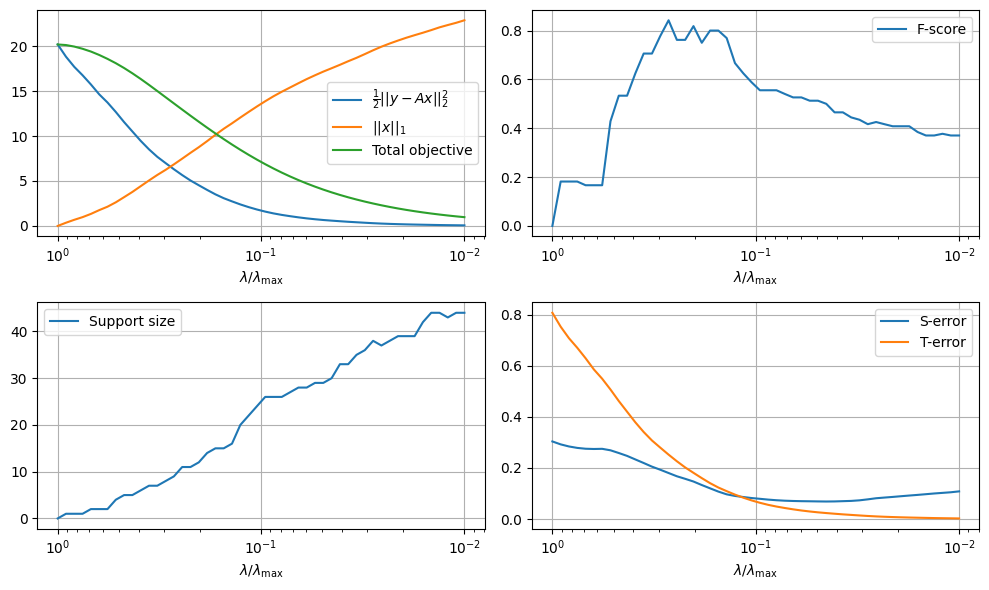

In [38]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6))

axs[0,0].plot(l_grid / l_max, obj_datafit, label=r"$\frac{1}{2} ||y-Ax||_2^2$")
axs[0,0].plot(l_grid / l_max, obj_penalty, label=r"$||x||_1$")
axs[0,0].plot(l_grid / l_max, obj_tot, label="Total objective")
axs[0,0].set_xlabel(r"$\lambda/\lambda_\max$")
axs[0,0].set_xscale("log")
axs[0,0].grid(True)
axs[0,0].legend()
axs[0,0].invert_xaxis()

axs[1,0].plot(l_grid / l_max, support_size, label="Support size")
axs[1,0].set_xlabel(r"$\lambda/\lambda_\max$")
axs[1,0].set_xscale("log")
axs[1,0].grid(True)
axs[1,0].legend()
axs[1,0].invert_xaxis()

axs[0,1].plot(l_grid / l_max, F_score, label="F-score")
axs[0,1].set_xlabel(r"$\lambda/\lambda_\max$")
axs[0,1].set_xscale("log")
axs[0,1].grid(True)
axs[0,1].legend()
axs[0,1].invert_xaxis()

axs[1,1].plot(l_grid / l_max, S_error, label="S-error")
axs[1,1].plot(l_grid / l_max, T_error, label="T-error")
axs[1,1].set_xlabel(r"$\lambda/\lambda_\max$")
axs[1,1].set_xscale("log")
axs[1,1].grid(True)
axs[1,1].legend()
axs[1,1].invert_xaxis()

fig.tight_layout()
plt.show()

### V - Applications

In [39]:
import numpy as np
from scipy.fftpack import dct, idct
from scipy.fft import dctn, idctn

def image_to_vector(img):
  p, p = img.shape
  return np.reshape(img, (p*p,))

def vector_to_image(vect):
  n = vect.shape[0]
  p = int(np.sqrt(n))
  return np.reshape(vect, (p, p))

def get_subspace_image(c, p):
    if c > p:
        raise ValueError("Parameter c must be lower than p")
    n = p**2
    V = np.zeros((n, c**2))
    counter = 0
    for i in range(c):
        for j in range(c):
            e = np.zeros((p, p))
            e[i, j] = 1
            V[:, counter] = image_to_vector(idctn(e, type=2))
            counter += 1
    return V

def generate_image_data(img_file, mn_ratio, c):
  X = mpimg.imread(img_file)
  x = image_to_vector(X)    
  n = x.size        
  p = int(np.sqrt(n))
  m = int(round(mn_ratio * n)) 
  V = get_subspace_image(c, p)
  M = np.random.randn(m, n)
  y = M @ x
  return V, M, y

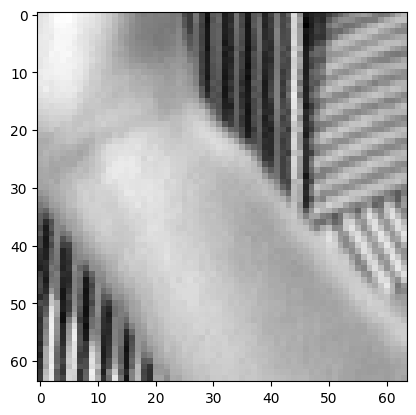

In [40]:
# Question 1

img = mpimg.imread("imagette.png")
plt.imshow(img, cmap='gray');

In [41]:
c = 10
mn_ratio = 0.25
V, M, y = generate_image_data("imagette.png", mn_ratio, c)
A = M @ V

lambda_max = np.linalg.norm(A.T @ y, np.inf)

alpha_hat_omp  = omp(A, y, c**2)
alpha_hat_iht, it = iht(A, y, c**2)
alpha_hat_Pl_1 = cvx_Pl(A, y, 1e-1 * lambda_max)
alpha_hat_Pl_2 = cvx_Pl(A, y, 1e-2 * lambda_max)
alpha_hat_Pl_3 = cvx_Pl(A, y, 1e-3 * lambda_max)
alpha_hat_Pl_4 = cvx_Pl(A, y, 1e-4 * lambda_max)

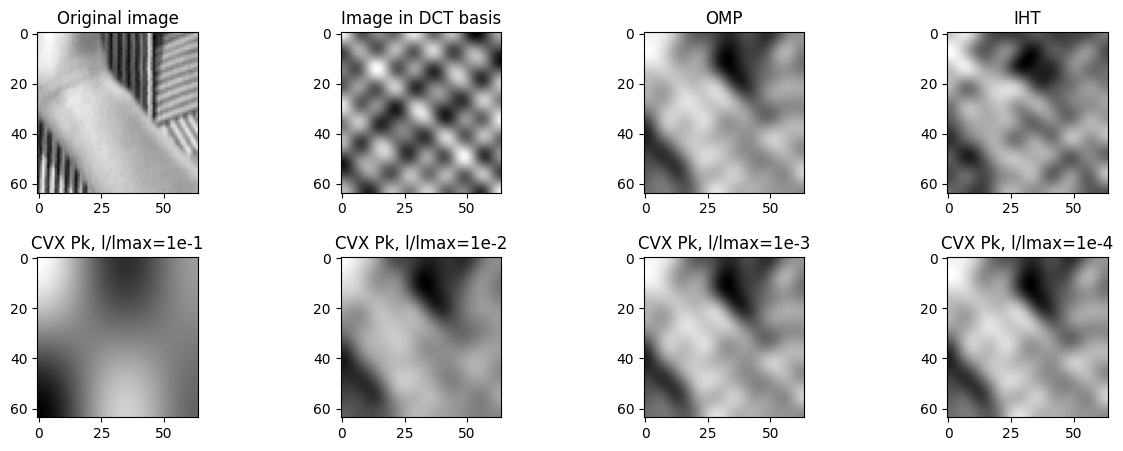

In [42]:

f, ax = plt.subplots(2, 4, figsize=(15,5), gridspec_kw={'hspace': 0.4})
ax[0,0].imshow(img, cmap='gray')
ax[0,0].set_title("Original image")
ax[0,1].imshow(vector_to_image(V @ x), cmap='gray')
ax[0,1].set_title("Image in DCT basis")
ax[0,2].imshow(vector_to_image(V @ alpha_hat_omp), cmap='gray')
ax[0,2].set_title("OMP")
ax[0,3].imshow(vector_to_image(V @ alpha_hat_iht), cmap='gray')
ax[0,3].set_title("IHT")
ax[1,0].imshow(vector_to_image(V @ alpha_hat_Pl_1), cmap='gray')
ax[1,0].set_title("CVX Pl, l/lmax=1e-1")
ax[1,1].imshow(vector_to_image(V @ alpha_hat_Pl_2), cmap='gray')
ax[1,1].set_title("CVX Pl, l/lmax=1e-2")
ax[1,2].imshow(vector_to_image(V @ alpha_hat_Pl_3), cmap='gray')
ax[1,2].set_title("CVX Pl, l/lmax=1e-3")
ax[1,3].imshow(vector_to_image(V @ alpha_hat_Pl_4), cmap='gray')
ax[1,3].set_title("CVX Pl, l/lmax=1e-4")

fig.tight_layout()